In [1]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from os.path import expanduser
import matplotlib as mpl
import seaborn as sns

sns.set_style("ticks")
fontpath = expanduser('/Users/horta/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': prop.get_name(),
    'text.usetex': True
}
mpl.rcParams.update(params)

In [11]:
from helpers import colors
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import json
import glob

cats = ["Alt-right", "Alt-lite", "Intellectual Dark Web", "Control"]
cats_all = ["Alt-right", "Alt-lite", "Intellectual Dark Web", "left",
            "center", "left-center", "right-center", "right"]
cats_to_control = ["left", "center", "left-center", "right-center", "right"]
SRC = "/Users/horta/Dropbox/data/youtube_radicalization/"


In [3]:
df_sources = pd.read_csv(SRC + "/sources_final_trimmed.csv")
df_sources = df_sources.set_index("Id")
df_sources.Category = df_sources.Category.apply(lambda x: x if x not in cats_to_control else "Control")

channels = {}
with open(SRC + "/rc/rec_base.jsonl") as f:
    for line in f.readlines():
        tmp = json.loads(line)
        channels[tmp["channel_id"]] = tmp

G = nx.DiGraph()

G.add_node("Other", category="Other", subscriberCount=0)

for _, edge in channels.items():
    
    if edge["channel_id"] not in df_sources.index or \
       df_sources.loc[edge["channel_id"], "Category"] not in cats:
        continue
    
    G.add_node(edge["channel_id"], name=edge["name"],
               videoCount=int(edge["statistics"]["videoCount"]),
               viewCount=int(edge["statistics"]["viewCount"]),
               subscriberCount=int(edge["statistics"]["subscriberCount"]),
               category=df_sources.loc[edge["channel_id"], "Category"] 
               )

for v in glob.glob(SRC + "/rc/*.jsonl"):
    with open(v) as f:
        for line in f.readlines():
            tmp = json.loads(line)
            channels[tmp["channel_id"]]["edges"] += tmp['edges']

count_edges = 0
for _, edge in channels.items():
    
    if edge["channel_id"] not in df_sources.index or \
       df_sources.loc[edge["channel_id"], "Category"] not in cats:
        continue
    count_edges += len(edge["edges"])

    relevant_edges = [actual_edge["channel_id"] for actual_edge in edge["edges"]
                          if actual_edge["type"].lower() in ["related channels", "canais relacionados"]]

    relevant_edges = [{"channel_id": x, 
            "count": relevant_edges.count(x),
            } for x in set(relevant_edges)]

    for actual_edge in relevant_edges:
        if G.has_node(actual_edge["channel_id"]):
            G.add_edge(edge["channel_id"], actual_edge["channel_id"],
                       count=actual_edge["count"],
                      )
        else:
            G.add_edge(edge["channel_id"], "Other",
                       count=actual_edge["count"],
                      )

def bla(G, i, j, count, edges):
    G[i][j]["pct"] = count/sum([G[i][edge]["count"] for edge in edges])
[bla(G, i, j, tmp["count"], G[i]) for i,j, tmp in G.edges(data=True)]

nx.write_graphml(G, SRC + "/channels_graph.graphml")

print("We are looking at {} collected recommendations!".format(count_edges))

We are looking at 31418 collected recommendations!


In [4]:
lambdas = [
    lambda x:  df_sources.loc[x, "Category"] == "Alt-lite",
    lambda x:  df_sources.loc[x, "Category"] == "Intellectual Dark Web",
    lambda x:  df_sources.loc[x, "Category"] == "Alt-right",
    lambda x:  df_sources.loc[x, "Category"] == "Control"
          ]

titles = [
    "Alt-lite",
    "I.D.W.",
    "Alt-right",
    "Control"
]

df_list = []
c = {}
for l, t in zip(lambdas, titles):

    node_list = [k for k, n in  G.nodes.data() if n["category"] != "Other" and l(k)]
    print(t)
    subs = np.array([G.nodes[n]["subscriberCount"] for n in node_list])
    subs = subs/np.sum(subs)
    print(sum(subs))
    cats_nodes = np.array([G.nodes[n]["category"] for n in node_list])
    
    print(t, sum([s for s,c in zip(subs, cats_nodes) if c =="Alt-right"]))
    print(t, sum([s for s,c in zip(subs, cats_nodes) if c =="Alt-lite"]))
    print(t, sum([s for s,c in zip(subs, cats_nodes) if c =="Intellectual Dark Web"]))
    print(t, sum([s for s,c in zip(subs, cats_nodes) if c =="Control"]))
    print(len(node_list))
    print(len(subs))

    num_its = 10000
    num_steps = 6
    c = {**{(cat,t):np.zeros((num_its, num_steps)) for cat in cats}, **c}

    for it in range(num_its):
        candidates = node_list
        weight = subs
        c_ = False
        for k in range(num_steps):
            n = np.random.choice(candidates, p = weight)
            if n == "Other":
                break
            cat = df_sources.loc[n, "Category"]
            df_list.append({"channel_id": n, 
                            "category":cat,
                            "step": k,
                            "Starting": t})
            c[(cat,t)][it, k:] = 1
            tmp = [(j, G[i][j]["count"]) for i,j in list(G.out_edges(n))]
            if len(tmp) == 0:
                k += 1
                break
            candidates, weight = list(zip(*tmp))
            weight = [w/sum(weight) for w in weight]
        while k < num_steps:
            df_list.append({"channel_id": "none", 
                            "category":"Other",
                            "step": k,
                            "Starting": t})  
            k += 1
df = pd.DataFrame(df_list)
df["isar"] = (df.category == "Alt-right").astype(float)
df["isidw"] = (df.category == "Intellectual Dark Web").astype(float)
df["isal"] = (df.category == "Alt-lite").astype(float)
df["isctrl"] = (df.category == "Control").astype(float)

Alt-lite
1.0000000000000002
Alt-lite 0
Alt-lite 1.0000000000000002
Alt-lite 0
Alt-lite 0
114
114
I.D.W.
0.9999999999999998
I.D.W. 0
I.D.W. 0
I.D.W. 0.9999999999999998
I.D.W. 0
89
89
Alt-right
1.0000000000000002
Alt-right 1.0000000000000002
Alt-right 0
Alt-right 0
Alt-right 0
88
88
Control
1.0
Control 0
Control 0
Control 0
Control 1.0
68
68


In [5]:
df[(df.Starting == "Alt-right") & (df.step == 0)]

,channel_id,category,step,Starting,isar,isidw,isal,isctrl
121922,UCVO8YsD87ibqRGIJ7o8sOzg,Alt-right,0,Alt-right,1.0,0.0,0.0,0.0
121928,UCFUC7NaTxZanB_FVOJN92eg,Alt-right,0,Alt-right,1.0,0.0,0.0,0.0
121934,UC94FYUJYBqq4CHPhfJUCxDw,Alt-right,0,Alt-right,1.0,0.0,0.0,0.0
121940,UChBsOxskMpDmBAsgJ91fKcg,Alt-right,0,Alt-right,1.0,0.0,0.0,0.0
121946,UChBsOxskMpDmBAsgJ91fKcg,Alt-right,0,Alt-right,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
183645,UClMWnUHbxJKJLUgloN1mPUA,Alt-right,0,Alt-right,1.0,0.0,0.0,0.0
183651,UCN0-RRaxMgh86eOwndAklxw,Alt-right,0,Alt-right,1.0,0.0,0.0,0.0
183657,UCFUC7NaTxZanB_FVOJN92eg,Alt-right,0,Alt-right,1.0,0.0,0.0,0.0
183664,UClMWnUHbxJKJLUgloN1mPUA,Alt-right,0,Alt-right,1.0,0.0,0.0,0.0


In [6]:
helper_edges_count = {}
df_list = []
for c1, c2 in itertools.product(cats + ["Other"], repeat=2):
    total_src = sum([G[u][v]["count"] for u, v in G.edges if G.nodes[u]["category"] == c1])
    val = sum([G[u][v]["count"] for u, v in G.edges if G.nodes[u]["category"] == c1 and 
                                                     G.nodes[v]["category"]  == c2])
    try:
        helper_edges_count[(c1,c2)] = str(round(val/total_src*100,2))+ "\%"
        val
    except:
        helper_edges_count[(c1,c2)] = 0
    
    c1 = c1.replace("Intellectual Dark Web", "I.D.W.")
    c2 = c2.replace("Intellectual Dark Web", "I.D.W.")
    df_list.append({"Source":c1, "Destination":c2, "val": round(val/total_src*100,2) if total_src != 0 else 0})
    
df_edges = pd.DataFrame(df_list)
df_edges = df_edges.pivot(index='Source', columns='Destination', values='val')

In [9]:
print(df_edges.to_latex())

\begin{tabular}{lrrrrr}
\toprule
Destination &  Alt-lite &  Alt-right &  Control &  I.D.W. &  Other \\
Source    &           &            &          &         &        \\
\midrule
Alt-lite  &     56.75 &       3.48 &     2.90 &   14.08 &  22.78 \\
Alt-right &     43.87 &      26.28 &     1.38 &    9.09 &  19.37 \\
Control   &      4.23 &       0.00 &    27.89 &    4.79 &  63.10 \\
I.D.W.    &     23.27 &       0.00 &     3.17 &   53.66 &  19.90 \\
Other     &      0.00 &       0.00 &     0.00 &    0.00 &   0.00 \\
\bottomrule
\end{tabular}



findfont: Font family ['Linux Libertine Display'] not found. Falling back to DejaVu Sans.


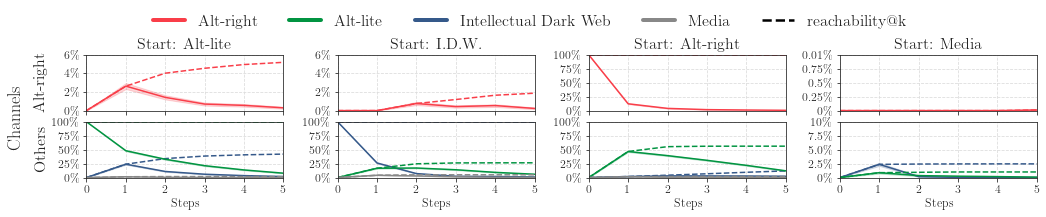

In [8]:
fig = plt.figure(constrained_layout=False, figsize=(16.5,2.2))
gs = fig.add_gridspec(nrows=2, ncols=4, wspace=0.275, hspace=0.2, top=0.9, left=0.1)

axes = [
    fig.add_subplot(gs[0, 0]), 
    fig.add_subplot(gs[0, 1]), 
    fig.add_subplot(gs[0, 2]), 
    fig.add_subplot(gs[0, 3]),
]

for idx, (ax, tt) in enumerate(list(zip(axes, titles))):
    df_tmp = df[df["Starting"] == tt]
    
    ax.plot(list(range(6)), c["Alt-right", tt].mean(axis=0), "--", color=colors["Alt-right"])
    sns.lineplot(x="step", y="isar", data=df_tmp, color=colors["Alt-right"], ax=ax)
    ax.set_ylim([0, 0.06])
    ax.set_xticks(list(range(6)))
    ax.set_xlim([0,5])
    ax.set_yticks([0, 0.02, 0.04, 0.06])
    ax.xaxis.grid(color='#DCDCDC', linestyle='dashed')
    ax.yaxis.grid(color='#DCDCDC', linestyle='dashed')
    ax.set_title("Start: " + tt.replace("Control", "Media"))
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yticklabels(["0\%", "2\%", "4\%", "6\%"])
    ax.set_xticklabels([])
    
    if idx == 0:
      ax.set_ylabel("Alt-right", fontsize=16, labelpad=17)

axes[-1].set_ylim([0, 0.01])
axes[-1].set_yticks([0, 0.0025, 0.005, 0.0075, 0.01])
axes[-1].set_yticklabels(["0\%", "0.25\%", "0.5\%", "0.75\%", "0.01\%"])

axes[-2].set_ylim([0, 1])
axes[-2].set_yticks([0, 0.25, 0.5, 0.75, 1])
axes[-2].set_yticklabels(["0\%", "25\%", "50\%", "75\%", "100\%"])

custom_lines = [Line2D([0], [0], color=colors[cat], lw=4) for cat in cats] + \
                [Line2D([0], [0], color="black", lw=2.5, ls="--")]
axes[2].legend(custom_lines, cats[:-1] + ['Media'] + ["reachability@k"], loc="upper center", ncol=5, bbox_to_anchor=(-0.3, 2), 
               frameon=False, fontsize=16)
        
axes = [
    fig.add_subplot(gs[1, 0]), 
    fig.add_subplot(gs[1, 1]), 
    fig.add_subplot(gs[1, 2]), 
    fig.add_subplot(gs[1, 3]),
]

for idx, (ax, tt) in enumerate(list(zip(axes, titles))):
    df_tmp = df[df["Starting"] == tt]
    
    ax.plot(list(range(6)), c["Intellectual Dark Web", tt].mean(axis=0), "--", 
            color=colors["Intellectual Dark Web"])
    sns.lineplot(x="step"
, y="isidw", data=df_tmp, color=colors["Intellectual Dark Web"], ax=ax)
    
    ax.plot(list(range(6)), c["Alt-lite", tt].mean(axis=0), "--", 
            color=colors["Alt-lite"])
    sns.lineplot(x="step", y="isal", data=df_tmp, color=colors["Alt-lite"], ax=ax)
    
    ax.plot(list(range(6)), c["Control", tt].mean(axis=0), "--", 
            color=colors["Control"])
    if tt != "Control":
        sns.lineplot(x="step", y="isctrl", data=df_tmp, color=colors["Control"], ax=ax)
    ax.set_ylim([0, 1])
    ax.set_xticks(list(range(6)))
    ax.set_xlim([0,5])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.xaxis.grid(color='#DCDCDC', linestyle='dashed')
    ax.yaxis.grid(color='#DCDCDC', linestyle='dashed')
    ax.set_ylabel("")
    ax.set_title("")
    ax.set_xlabel("Steps")
    ax.set_yticklabels(["0\%", "25\%", "50\%", "75\%", "100\%"])

axes[0].set_ylabel("Others", fontsize=16)
axes[-1].set_ylim([0, 0.10])

axes[-1].set_yticks([0, 0.025, 0.05, 0.075, 0.1])
axes[-1].set_yticklabels(["0\%", "2.5\%", "5.0\%", "7.5\%", "10\%"])
fig.text(0.04, 0.5, 'Channels', va='center', ha='center', rotation='vertical', fontsize=18)

fig.savefig("../imgs/channels_graphs.pdf", bbox_inches='tight')
fig.savefig("../imgs/channels_graphs.png", bbox_inches='tight')